In [ ]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import datetime
import time

In [ ]:
#Default dimensions
img_width, img_height = 224, 224

#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'

# loading up our datasets
train_data_dir = '/content/drive/MyDrive/newTrain_cow'
validation_data_dir = '/content/drive/MyDrive/validate_cow'
test_data_dir = '/content/drive/MyDrive/test_cow'

# number of epochs to train top model
epochs = 7

# batch size used by flow_from_directory and predict_generator
batch_size = 50

In [ ]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

In [ ]:
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
     train_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 843 images belonging to 2 classes.


<ipython-input-5-da9d381776a6>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time:  0:06:36.125139


In [ ]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(
     validation_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = vgg16.predict_generator(
     generator, predict_size_validation)

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 401 images belonging to 2 classes.


<ipython-input-7-92efa63fcc3f>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:02:54.770533


In [ ]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [ ]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(
     test_data_dir,
     target_size=(img_width, img_height),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False)

nb_test_samples = len(generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

bottleneck_features_test = vgg16.predict_generator(
     generator, predict_size_test)

np.save('bottleneck_features_test.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 257 images belonging to 2 classes.


<ipython-input-9-5781add6c092>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(


Time:  0:02:23.851697


In [ ]:
#training data
generator_top = datagen.flow_from_directory(
         train_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode='categorical',
         shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

# get the class lebels for the training data, in the original order
train_labels = generator_top.classes

# convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 843 images belonging to 2 classes.


In [ ]:
#validation data
generator_top = datagen.flow_from_directory(
         validation_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_validation_samples = len(generator_top.filenames)

validation_data = np.load('bottleneck_features_validation.npy')


validation_labels = generator_top.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 401 images belonging to 2 classes.


In [ ]:
#testing data
generator_top = datagen.flow_from_directory(
         test_data_dir,
         target_size=(img_width, img_height),
         batch_size=batch_size,
         class_mode=None,
         shuffle=False)

nb_test_samples = len(generator_top.filenames)

test_data = np.load('bottleneck_features_test.npy')


test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 257 images belonging to 2 classes.


In [ ]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(train_data, train_labels,
      epochs=7,
      batch_size=batch_size,
      validation_data=(validation_data, validation_labels))

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


17/17 [==============================] - 1s 44ms/step - loss: 0.0321 - acc: 0.9846 - val_loss: 6.4213 - val_acc: 0.3940
Epoch 2/7
17/17 [==============================] - 0s 26ms/step - loss: 6.7377e-04 - acc: 1.0000 - val_loss: 7.2389 - val_acc: 0.3940
Epoch 3/7
17/17 [==============================] - 0s 27ms/step - loss: 3.0858e-04 - acc: 1.0000 - val_loss: 8.2708 - val_acc: 0.3940
Epoch 4/7
17/17 [==============================] - 1s 30ms/step - loss: 1.1281e-04 - acc: 1.0000 - val_loss: 9.1301 - val_acc: 0.3940
Epoch 5/7
17/17 [==============================] - 0s 30ms/step - loss: 6.4875e-05 - acc: 1.0000 - val_loss: 10.4445 - val_acc: 0.3940
Epoch 6/7
17/17 [==============================] - 1s 32ms/step - loss: 3.0477e-05 - acc: 1.0000 - val_loss: 11.4407 - val_acc: 0.3940
Epoch 7/7
9/9 [==============================] - 0s 8ms/step - loss: 12.4369 - acc: 0.3940
[INFO] accuracy: 39.40%
[INFO] Loss: 12.436874389648438
Time:  0:00:06.118109


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,514,052
Trainable params: 2,514,052
Non-

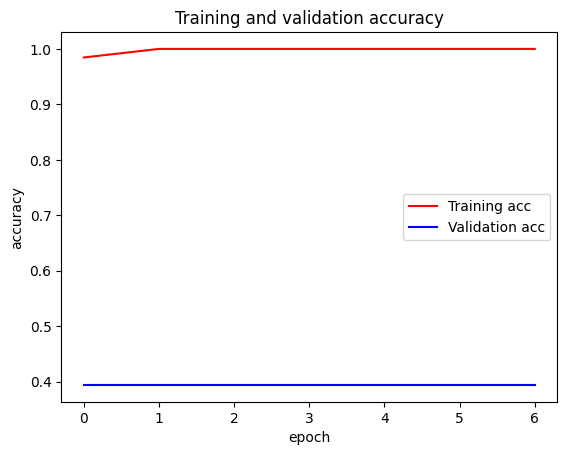

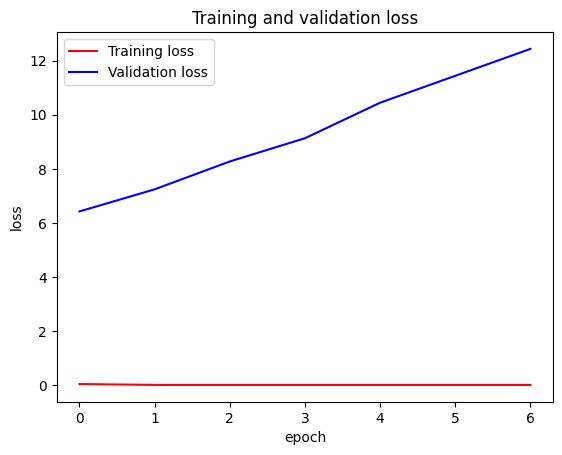

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

9/9 [==============================] - 0s 9ms/step - loss: 7.5893 - acc: 0.5486


[7.589257717132568, 0.548638105392456]

In [ ]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 4.49358344e-01 ... 0.00000000e+00
    1.01945698e+00 0.00000000e+00]
   [4.55835164e-02 0.00000000e+00 2.97793686e-01 ... 0.00000000e+00
    1.02238917e+00 0.00000000e+00]
   [1.47521138e-01 0.00000000e+00 7.10781217e-02 ... 0.00000000e+00
    1.02337241e+00 0.00000000e+00]
   ...
   [5.47151208e-01 0.00000000e+00 6.42008483e-01 ... 0.00000000e+00
    1.02679360e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 4.55117911e-01 ... 0.00000000e+00
    9.97057438e-01 0.00000000e+00]
   [2.17364386e-01 0.00000000e+00 8.93873453e-01 ... 0.00000000e+00
    9.37693596e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.30769563e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.75810575e-01 ... 0.00000000e+00
    1.16396761e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.24509543e-01 ... 0.00000000e+00
    1.15071726e+00 0.00000000e+00]
   ...
   [6.58539295e-01 0.00000000e+00 1.91163182e-0

In [ ]:
animals = ['Cow', 'No_Cow']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

         Cow       0.55      1.00      0.71       141
      No_Cow       0.00      0.00      0.00       116

   micro avg       0.55      0.55      0.55       257
   macro avg       0.27      0.50      0.35       257
weighted avg       0.30      0.55      0.39       257
 samples avg       0.55      0.55      0.55       257



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


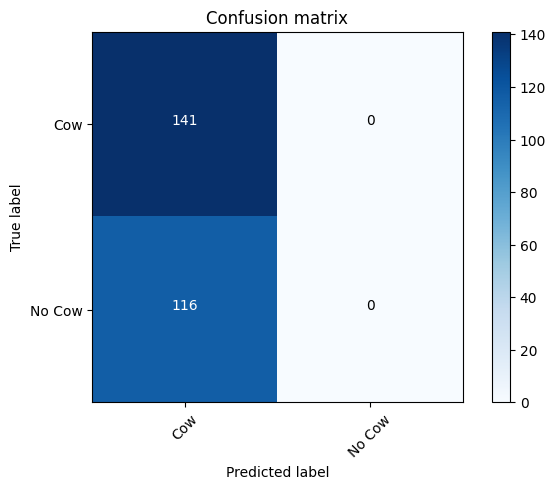

In [ ]:
plot_confusion_matrix(confusion_matrix, ['Cow' , 'No Cow'])

Normalized confusion matrix


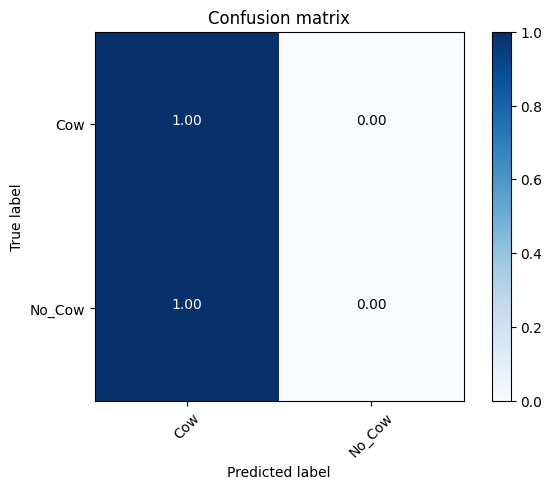

In [ ]:
plot_confusion_matrix(confusion_matrix,
                      ['Cow','No_Cow'],
                     normalize=True)

In [ ]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.
    return image

In [ ]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 4.49358344e-01 ... 0.00000000e+00
    1.01945698e+00 0.00000000e+00]
   [4.55835164e-02 0.00000000e+00 2.97793686e-01 ... 0.00000000e+00
    1.02238917e+00 0.00000000e+00]
   [1.47521138e-01 0.00000000e+00 7.10781217e-02 ... 0.00000000e+00
    1.02337241e+00 0.00000000e+00]
   ...
   [5.47151208e-01 0.00000000e+00 6.42008483e-01 ... 0.00000000e+00
    1.02679360e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 4.55117911e-01 ... 0.00000000e+00
    9.97057438e-01 0.00000000e+00]
   [2.17364386e-01 0.00000000e+00 8.93873453e-01 ... 0.00000000e+00
    9.37693596e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.30769563e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.75810575e-01 ... 0.00000000e+00
    1.16396761e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.24509543e-01 ... 0.00000000e+00
    1.15071726e+00 0.00000000e+00]
   ...
   [6.58539295e-01 0.00000000e+00 1.91163182e-0

In [ ]:
def test_single_image(path):
    animals = ['Cow','No_Cow']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)

    preds = model.predict(bt_prediction)

    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = np.argmax(preds[0])
    class_dictionary = generator_top.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}
    print("ID: {}, Label: {}".format(class_predicted, inv_map[class_predicted]))
    return load_img(path)


In [ ]:
path = '/content/cow2.jpg'

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 32ms/step
ID: 0, Label: Cow 100.0%
ID: 1, Label: No_Cow 0.0%
Final Decision:
.
..
...
ID: 0, Label: COW


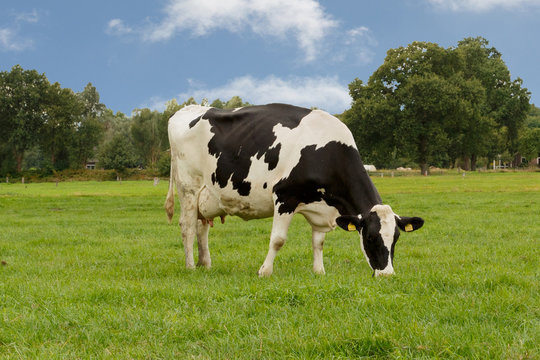

In [ ]:
test_single_image(path)